In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision

# Concise Implementation of Softmax Regression

* In this notebook, we will use high-level PyTorch functionalities to implement softmax regression for classification.

* We will use the [fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which is composed of labeled images of clothes and accessories.

* The following function is used to load the dataset. You don't need to understand it for now.

In [2]:
# You don't need to understand this function for now.
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [torchvision.transforms.ToTensor()]
    if resize:
        trans.insert(0, torchvision.transforms.Resize(resize))
    trans = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

In [3]:
batch_size = 256 # Defines the batch size
train_iter, test_iter = load_data_fashion_mnist(batch_size) # Loads the fashion MNIST dataset. `train_iter` and `test_iter` are `DataLoader` objects.

In [4]:
X, y = next(iter(train_iter)) # Requests the first training batch
print(X.size()) # 256 images per batch. Each image is represented by a 1 x 28 x 28 tensor (number of channels x height x width). The images are grayscale, so there is a single channel.
print(y.size()) # 256 targets. Each target is a number between 0 and 9. The classification problem has 10 clases.

torch.Size([256, 1, 28, 28])
torch.Size([256])


* The following code displays some images from the first training batch.

In [5]:
from google.colab.patches import cv2_imshow

class_labels = ['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot'] # Pre-defined class labels

for i in range(3):
    print(f'\nImage {i} ({class_labels[int(y[i])]}):\n') # Prints the index `i` and the label associated to the `i`-th image.
    cv2_imshow(X[i].numpy().transpose(1, 2, 0) * 255) # Converts and displays the `i`-th image in the batch.


Image 0 (bag):




Image 1 (sneaker):




Image 2 (sandal):



# Model definition and initialization

* Each image is a rank 3 tensor with $1 \cdot 28 \cdot 28 = 784$ elements. We will *flatten* each image into a $784$-dimensional vector (observation).

* Because the fashion MNIST dataset has $10$ classes, the softmax regression model will output a $10$-dimensional vector.

* Therefore, we need a weight matrix $\mathbf{W} \in \mathbb{R}^{784 \times 10}$ and a bias vector $\mathbf{b} \in \mathbb{R}^{10 \times 1}$.

* We will initialize the weight matrix using samples from a normal distribution and the bias vector to zero.

* We will compute the logit matrix $\mathbf{O}$ inside a subclass of `torch.nn.Module`. This is how neural networks are typically implemented in PyTorch.

* The class `torch.nn.Module` requires implementing the method `forward`, which should define the forward pass for a batch of observations.


In [6]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__() # Initializes superclass

        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.Linear1 = torch.nn.Linear(num_inputs, num_outputs) # Creates a linear layer

        torch.nn.init.normal_(self.Linear1.weight, std=0.01) # Initializes the weight matrix
        torch.nn.init.zeros_(self.Linear1.bias) # Initializes the bias vector

    def forward(self, x):
        x = x.view(-1, self.num_inputs) # Reshapes the (`batch_size`, 1, 28, 28) batch of images `x` into a (`batch_size`, 784) batch of observations `x`
        out = self.Linear1(x) # A linear layer multiplies `x` by a weight matrix and adds a bias vector (to each row, using broadcasting)
        return out # Returns a (`batch_size`, 10) logits matrix

num_inputs = 784 # Number of features (inputs)
num_outputs = 10 # Number of classes (outputs)
net = Net(num_inputs, num_outputs)
print(net)

Net(
  (Linear1): Linear(in_features=784, out_features=10, bias=True)
)


# Loss Function

* The *neural network* defined above computes the logits matrix $\mathbf{O}$, not the prediction matrix $\mathbf{\hat{Y}} = \text{softmax}(\mathbf{O})$.

* This is because Pytorch provides a class called `CrossEntropyLoss` that implements the desired cross entropy loss for softmax regression but requires a logits matrix $\mathbf{O}$ instead of the prediction matrix $\mathbf{\hat{Y}}$.

* The class `CrossEntropyLoss` implements the cross entropy loss in a way that avoids numerical instabilities that would result from a naive implementation.

In [7]:
loss = torch.nn.CrossEntropyLoss()

# Optimization Algorithm


* We will employ minibatch stochastic gradient descent with a learning rate of $0.1$ as the optimization algorithm.

* Because we implemented a subclass of `torch.nn.Module`, the model parameters can be accessed through the method `parameters`.


In [8]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

# Evaluation

* Recall that the highest element of a logits vector determines which class will be predicted.

* We can use this to compute the number of correct predictions per batch.

In [9]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

# Example: 1 correct classification,
y = torch.tensor([2, 1])
logits = torch.tensor([[0.1, 0.3, 0.6], [0.5, 0.2, 0.3]])
print(correct(logits, y))

tensor(1.)


* We can use the previous function to compute the accuracy of our model in a given dataset by accumulating the number of correct predictions across batches and then dividing that number by the number of examples in the dataset.

In [10]:
def evaluate_metric(net, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.)
    n = torch.tensor(0.)
    for X, y in data_iter:
        logits = net(X)
        c += metric(logits, y)
        n += len(y)

    return c / n

In [11]:
print(f'Training accuracy: {evaluate_metric(net, train_iter, correct)}. Testing accuracy: {evaluate_metric(net, test_iter, correct)}.')

Training accuracy: 0.17496666312217712. Testing accuracy: 0.1770000010728836.


* The accuracy of the model before training should be low. The expected accuracy of randomly guessing classes is $0.1$, as there are $10$ classes and the training/testing datasets are balanced (have the same number of examples for each class).


# Training

* The following code implements the training loop for the softmax regression model.

* The training/testing dataset accuracy is displayed after each epoch.

* **Important:** it is a methodological mistake to compute performance metrics on the *testing* dataset for the purposes of hyperparameter tuning. A *validation* dataset should be used for that purpose, even if it requires splitting the original training dataset into a training dataset and a validation dataset. The *test* dataset should only be used to evaluate the performance of the final set of hyperparameters, in order to assess generalization.


Epoch 1/5.
Training accuracy: 0.7780333161354065. Testing accuracy: 0.7642999887466431.

Epoch 2/5.
Training accuracy: 0.7871333360671997. Testing accuracy: 0.7756999731063843.

Epoch 3/5.
Training accuracy: 0.8317833542823792. Testing accuracy: 0.8187000155448914.

Epoch 4/5.
Training accuracy: 0.8351166844367981. Testing accuracy: 0.8226000070571899.

Epoch 5/5.
Training accuracy: 0.840583324432373. Testing accuracy: 0.8267999887466431.


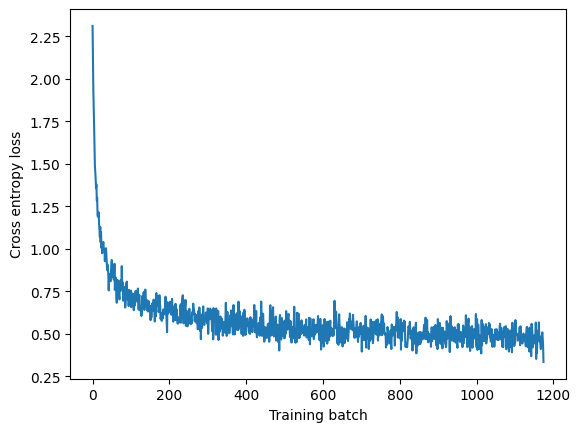

In [12]:
losses = [] # Stores the loss for each training batch

num_epochs = 5
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    for X, y in train_iter:
        logits = net(X) # Computes the logits for the batch of images `X`

        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch

    with torch.no_grad(): # Computing performance metrics does not require gradients
        print(f'Training accuracy: {evaluate_metric(net, train_iter, correct)}. Testing accuracy: {evaluate_metric(net, test_iter, correct)}.') # Computes and displays training/testing dataset accuracy.

plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

# [Storing this notebook as a `pdf`]

In [14]:
%%capture
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

# Set the path to this notebook below (add \ before spaces). The output `pdf` will be stored in the corresponding folder.
!jupyter nbconvert --to pdf /content/gdrive/My\ Drive/Colab\ Notebooks/nndl/week_04/lecture/02_Softmax_Regression_Concise.ipynb

# If having issues, save this notebook (File > Save) and restart the session (Runtime > Restart session) before running this cell. To debug, remove the first line (`%%capture`).